In [8]:
import sys
import os
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sys.path.append('..\..')
from utils.post_processing_utils import get_all_experimental_records, remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.plotting import multi_conditions_plot
from set_global_params import processed_data_path, silence_mice, raw_tracking_path, spreadsheet_path, reproduce_figures_path
from utils.stats import cohen_d_paired
import shutil

In [9]:
def filter_trials_around_reaction_time(side_data, window_around_mean=0.2):
    data = side_data.reset_index(drop=True)
    reaction_times = data['reaction times'].values
    median_reaction_time = np.nanmedian(reaction_times)
    valid_trials = np.where(
            np.logical_and(np.greater_equal(reaction_times, median_reaction_time - window_around_mean),
                           np.less_equal(reaction_times, median_reaction_time + window_around_mean)))
    valid_data = data.loc[valid_trials]
    return valid_data

In [10]:
def get_trial_data(mouse, date):
    saving_folder = processed_data_path + mouse + '\\'
    restructured_data_filename = mouse + '_' + date + '_' + 'restructured_data.pkl'
    trial_data = pd.read_pickle(saving_folder + restructured_data_filename)
    return trial_data

In [11]:
def get_silence_trial_nums(mouse_id, trial_data, contra_trial_nums, fiber_side):
    if mouse_id in ['SNL_photo37', 'SNL_photo43']:
        fiber_options = ['left', 'right']
        contra_choice_ind = np.where(np.array(fiber_options) != fiber_side)[0][0] + 1
        post_change_trials = trial_data[(trial_data['Trial num']>149) & (trial_data['State type'] == 1)]
        silence_correct_trials = post_change_trials[(post_change_trials['Response'] == contra_choice_ind) & (post_change_trials['Trial outcome'] == 1)] 
        silence_trial_type = silence_correct_trials['Trial type'].unique()[0]
        silence_trials = post_change_trials[post_change_trials['Trial type'] == silence_trial_type]
        cot_trials = trial_data[(trial_data['Trial num']<=149) & (trial_data['State type'] == 1)]
    else:
        cot_trials = trial_data[trial_data['Sound type'] == 0]
        silence_trials = trial_data[trial_data['Sound type'] == 1]
    _, cot_inds, _ = np.intersect1d(contra_trial_nums, cot_trials['Trial num'], return_indices=True)
    _, silence_inds, _ = np.intersect1d(contra_trial_nums, silence_trials['Trial num'], return_indices=True)
    return cot_inds, silence_inds

In [13]:
mice = silence_mice
turn_angles = []
stimulus = []
speeds = []
mice_for_df = []
repro_dir = os.path.join(reproduce_figures_path,'ED_fig5')

for mouse in mice:
    recording_site = 'tail'
    all_experiments = get_all_experimental_records()
    all_experiments = remove_unsuitable_recordings(all_experiments)
    experiments_to_process = all_experiments[
        (all_experiments['mouse_id'] == mouse) & (all_experiments['recording_site'] == recording_site) & (all_experiments['experiment_notes'] == 'silence')]
    dates = experiments_to_process['date'].values[-4:]
    date = dates[0]
    save_out_folder = '{}{}\\{}\\'.format(raw_tracking_path, mouse, date)
    movement_param_file = os.path.join(save_out_folder, 'APE_tracking{}_{}.pkl'.format(mouse, date)) 
    repro_filename = os.path.join(repro_dir, f'tracking_and_photometry_{mouse}_{date}.pkl')
    if not os.path.exists(repro_filename):
        shutil.copy(movement_param_file, repro_filename)
    movement_df = pd.read_pickle(repro_filename).dropna()
    movement_df['abs fitted max cumsum ang vel'] = movement_df['fitted max cumsum ang vel'].abs()

    contra_data = movement_df[movement_df.side == 'contra']
    valid_contra_data = filter_trials_around_reaction_time(contra_data).reset_index(drop=True)
  
    contra_trial_numbers = valid_contra_data['trial numbers'].values
   # behavioural_data = get_trial_data(mouse, date)
    repro_file = os.path.join(repro_dir, f'silence_behavioural_data_{mouse}.csv') # this is either downloaded or made by ED_Fig5A.ipynb
    behavioural_data = pd.read_csv(repro_file)
    fiber_side = experiments_to_process['fiber_side'].values[0]
    cot_inds, silence_inds = get_silence_trial_nums(mouse, behavioural_data, contra_trial_numbers, fiber_side)
    cot_df = valid_contra_data.loc[cot_inds]
    silence_df = valid_contra_data.loc[silence_inds]
    cot_df['Stimulus'] = 'tones'
    silence_df['Stimulus'] = 'silence'
    all_stimuli_df = pd.concat([cot_df, silence_df])
    turn_angles.append(np.mean(cot_df['abs fitted max cumsum ang vel'].values))
    speeds.append(np.mean(cot_df['average speed'].values))
    stimulus.append('tones')
    mice_for_df.append(mouse)
    turn_angles.append(np.mean(silence_df['abs fitted max cumsum ang vel'].values))
    speeds.append(np.mean(silence_df['average speed'].values))
    stimulus.append('silence')
    mice_for_df.append(mouse)

In [14]:
silence_tones_with_movement = pd.DataFrame({'mouse': mice_for_df, 'stimulus': stimulus, 'turn angle': turn_angles, 'speed': speeds})

In [16]:
turn_angle_for_plot = silence_tones_with_movement.pivot(index='stimulus', columns='mouse', values='turn angle').sort_values('stimulus', ascending=False)
speed_for_plot = silence_tones_with_movement.pivot(index='stimulus', columns='mouse', values='speed').sort_values('stimulus', ascending=False)

In [20]:
if not os.path.exists(os.path.join(spreadsheet_path, 'ED_fig5', 'ED_fig5F_speed.csv')):
    speed_for_plot.to_csv(os.path.join(spreadsheet_path, 'ED_fig5', 'ED_fig5F_speed.csv'))
if not os.path.exists(os.path.join(spreadsheet_path, 'ED_fig5', 'ED_fig5G_turn_angle.csv')):
    turn_angle_for_plot.to_csv(os.path.join(spreadsheet_path, 'ED_fig5', 'ED_fig5G_turn_angle.csv'))

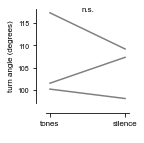

In [12]:
font = {'size': 7}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


fig, ax = plt.subplots(figsize=[2,2])
multi_conditions_plot(ax, turn_angle_for_plot, mean_line_color='#7FB5B5', mean_linewidth=0, show_err_bar=False)
plt.xticks([0, 1], ['tones', 'silence'], fontsize=8)
y = turn_angle_for_plot.T.to_numpy().max() + .2
h = .1
plt.ylabel('turn angle (degrees)', fontsize=8)
ax.text(.5, y+h, 'n.s.', ha='center', fontsize=8)
ax.set_xlabel(' ')

plt.tight_layout()


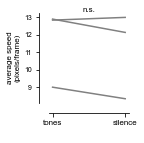

In [13]:
font = {'size': 7}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


fig, ax = plt.subplots(figsize=[2,2])
multi_conditions_plot(ax, speed_for_plot, mean_line_color='#7FB5B5', mean_linewidth=0, show_err_bar=False)
plt.xticks([0, 1], ['tones', 'silence'], fontsize=8)
y = speed_for_plot.T.to_numpy().max() + .2
h = .1
plt.ylabel('average speed\n(pixels/frame)', fontsize=8)
ax.text(.5, y+h, 'n.s.', ha='center', fontsize=8)
ax.set_xlabel(' ')

plt.tight_layout()


In [15]:
tones_data = silence_tones_with_movement[silence_tones_with_movement['stimulus'] == 'tones']
silence_data = silence_tones_with_movement[silence_tones_with_movement['stimulus'] == 'silence']

In [16]:
stats.ttest_rel(tones_data.speed, silence_data.speed)

Ttest_relResult(statistic=1.452795459716277, pvalue=0.28344242544517234)

In [17]:
_ = cohen_d_paired(tones_data.speed, silence_data.speed)

cohen d:  0.8387718497446588


In [16]:
stats.ttest_rel(tones_data['turn angle'], silence_data['turn angle'])

Ttest_relResult(statistic=0.3650062534470542, pvalue=0.7500912236679296)

In [18]:
_ = cohen_d_paired(tones_data['turn angle'], silence_data['turn angle'])

cohen d:  0.21073645868355353
